# Anomaly detection
### NASA acoustics and vibration - PCA

<div style="text-align: right"> <b>Author : Kwang Myung Yu</b></div> 

<div style="text-align: right"> Initial upload: 2020.12.25 </div> 
<div style="text-align: right"> Last update: 2020.12.25</div> 

NASA의Acoustics and Vibration Database를 사용한다.

참고자료
- https://ti.arc.nasa.gov/tech/dash/groups/pcoe/prognostic-data-repository/  
- https://github.com/BLarzalere/LSTM-Autoencoder-for-Anomaly-Detection  
- https://github.com/mhmd-ah/Anomaly_Detection  
- https://www.kaggle.com/rkuo2000/nasa-bearing-sensor-data/notebooks

### 0. 라이브러리 import

In [4]:
import os
import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
import scipy as sp
import datetime
import missingno as msno
import warnings; warnings.filterwarnings('ignore')
plt.style.use('ggplot')
%matplotlib inline

# Options for pandas
pd.options.display.max_columns = 30

In [6]:
mpl.rcParams['figure.figsize'] = (12, 5)
colors = plt.rcParams['axes.prop_cycle'].by_key()['color']

In [7]:
color_pal = [ '#ee4035', '#3385c6', '#fed766','#eb6841', '#708090', '#00a0b0', '#3b7dd8', '#fe4a49' , 
             '#2ab7ca', '#851e3e', '#2a4d69',  '#f7f7f7', '#edc951', '#54b2a9', '#ffffff', '#96ceb4', 
             '#ffeead', '#708090', '#be9b7b', '#feb2a8','#58668b',  '#4f372d', '#ECD59F', '#ABD1DC', 
             '#7E9680', '#E69D45', '#D4CFC9', '#E79796', '#C6C09C', '#dec3c3','#4b86b4', '#f9caa7', 
             '#d2d4dc', '#ebf4f6', '#29a8ab' ]

### 2. 데이터셋 살펴보기

In [35]:
dir = './Bearing_Sensor_Data'
os.listdir(dir)

['2004.02.16.00.02.39',
 '2004.02.14.14.32.39',
 '2004.02.15.14.32.39',
 '2004.02.12.11.22.39',
 '2004.02.13.11.22.39',
 '2004.02.16.02.22.39',
 '2004.02.14.16.12.39',
 '2004.02.15.16.12.39',
 '2004.02.12.13.02.39',
 '2004.02.13.13.02.39',
 '2004.02.16.04.42.39',
 '2004.02.13.08.32.39',
 '2004.02.15.12.52.39',
 '2004.02.14.12.52.39',
 '2004.02.13.17.42.39',
 '2004.02.12.17.42.39',
 '2004.02.12.17.52.39',
 '2004.02.13.17.52.39',
 '2004.02.14.12.42.39',
 '2004.02.15.12.42.39',
 '2004.02.13.08.22.39',
 '2004.02.16.04.52.39',
 '2004.02.13.13.12.39',
 '2004.02.12.13.12.39',
 '2004.02.15.16.02.39',
 '2004.02.14.16.02.39',
 '2004.02.16.02.32.39',
 '2004.02.13.11.32.39',
 '2004.02.12.11.32.39',
 '2004.02.15.14.22.39',
 '2004.02.14.14.22.39',
 '2004.02.16.00.12.39',
 '2004.02.16.00.32.39',
 '2004.02.15.09.52.39',
 '2004.02.14.09.52.39',
 '2004.02.15.14.02.39',
 '2004.02.14.14.02.39',
 '2004.02.13.11.12.39',
 '2004.02.12.11.12.39',
 '2004.02.16.02.12.39',
 '2004.02.15.16.22.39',
 '2004.02.14.16.

In [36]:
os.listdir(dir)[0]

'2004.02.16.00.02.39'

한개 파일만 열어보기

In [37]:
sample = pd.read_csv(os.path.join(dir,os.listdir(dir)[0]), sep = '\t', header = None)

In [38]:
sample

,0,1,2,3
0,0.039,-0.022,0.032,-0.022
1,0.020,0.115,-0.110,0.007
2,0.051,-0.037,-0.083,-0.076
3,0.076,-0.002,0.005,-0.017
4,0.093,0.005,-0.181,-0.024
...,...,...,...,...
20475,0.125,0.063,-0.059,-0.100
20476,0.085,0.144,-0.017,-0.046
20477,0.056,0.002,-0.066,-0.012
20478,0.095,-0.022,-0.173,0.027


- 한개 파일에는 10분간의 기록이 저장되어 있다.  
- 베어링의 기계적인 기능저하를 살펴 볼 것이기 때문이므로 10분 주기의 데이터로 만드는 것이 좋다.

전체 데이터 병합하기

In [39]:
data_dir = './Bearing_Sensor_Data'
merged_data = pd.DataFrame()

for filename in os.listdir(data_dir):
    dataset = pd.read_csv(os.path.join(data_dir, filename), sep = '\t')
    dataset_mean_abs = np.array(dataset.abs().mean())
    dataset_mean_abs = pd.DataFrame(dataset_mean_abs.reshape(1,4))
    dataset_mean_abs.index = [filename]
    merged_data = merged_data.append(dataset_mean_abs)
    
merged_data.columns = ['Bearing 1', 'Bearing 2', 'Bearing 3', 'Bearing 4']

In [40]:
merged_data.head()

,Bearing 1,Bearing 2,Bearing 3,Bearing 4
2004.02.16.00.02.39,0.060751,0.073686,0.077033,0.044211
2004.02.14.14.32.39,0.061577,0.074337,0.074244,0.043742
2004.02.15.14.32.39,0.061170,0.073761,0.074654,0.044231
2004.02.12.11.22.39,0.061665,0.073279,0.084879,0.044172
2004.02.13.11.22.39,0.060456,0.076069,0.079678,0.043469


- 일자별로 sorting이 되지 않아있다.  

인덱스를 datetime 포맷으로 변환하기

In [41]:
merged_data.index = pd.to_datetime(merged_data.index, 
                                   format = '%Y.%m.%d.%H.%M.%S')
merged_data = merged_data.sort_index()

In [42]:
merged_data.head()

,Bearing 1,Bearing 2,Bearing 3,Bearing 4
2004-02-12 10:32:39,0.058333,0.071832,0.083242,0.043067
2004-02-12 10:42:39,0.058995,0.074006,0.084435,0.044541
2004-02-12 10:52:39,0.060236,0.074227,0.083926,0.044443
2004-02-12 11:02:39,0.061455,0.073844,0.084457,0.045081
2004-02-12 11:12:39,0.061361,0.075609,0.082837,0.045118


In [46]:
merged_data.tail()

,Bearing 1,Bearing 2,Bearing 3,Bearing 4
2004-02-19 05:42:39,0.453335,0.161016,0.137440,0.119047
2004-02-19 05:52:39,0.337583,0.132400,0.144992,0.092125
2004-02-19 06:02:39,0.351111,0.152266,0.151299,0.100817
2004-02-19 06:12:39,0.001857,0.003732,0.003656,0.001786
2004-02-19 06:22:39,0.001168,0.000767,0.000716,0.001699


In [43]:
merged_data.to_csv('./Bearing_Sensor_Data//Averaged_BearingTest_Dataset.csv')

데이터 기본정보 살펴보기

In [44]:
merged_data.shape

(984, 4)

In [45]:
merged_data.describe()

,Bearing 1,Bearing 2,Bearing 3,Bearing 4
count,984.000000,984.000000,984.000000,984.000000
mean,0.080905,0.078532,0.081356,0.047822
std,0.040171,0.011779,0.011596,0.009541
min,0.001168,0.000767,0.000716,0.001699
25%,0.060765,0.074233,0.076832,0.043950
50%,0.062007,0.075203,0.078197,0.044524
75%,0.083223,0.077456,0.080600,0.048111
max,0.453335,0.161016,0.151299,0.119047


### 3. 학습/ 시험데이터 분리하기

In [48]:
train = merged_data['2004-02-12 10:52:39': '2004-02-13 23:52:39']
test = merged_data['2004-02-13 23:52:39':]
print("Training dataset shape:", train.shape)
print("Test dataset shape:", test.shape)

Training dataset shape: (223, 4)
Test dataset shape: (760, 4)


학습데이터 시각화하기

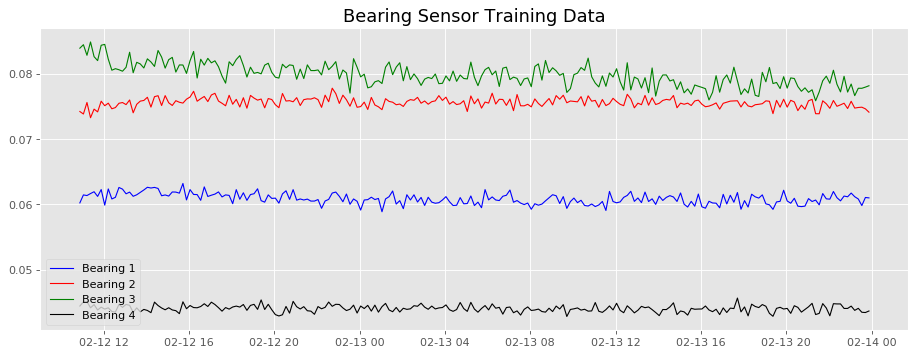

In [50]:
fig, ax = plt.subplots(figsize=(14, 5), dpi = 80)
ax.plot(train['Bearing 1'], label='Bearing 1', color='blue', animated = True, linewidth=1)
ax.plot(train['Bearing 2'], label='Bearing 2', color='red', animated = True, linewidth=1)
ax.plot(train['Bearing 3'], label='Bearing 3', color='green', animated = True, linewidth=1)
ax.plot(train['Bearing 4'], label='Bearing 4', color='black', animated = True, linewidth=1)
plt.legend(loc='lower left')
ax.set_title('Bearing Sensor Training Data', fontsize=16)
plt.show()

### 4. 데이터 정규화

MinMax 스케일러로 데이터 정규화

In [51]:
from sklearn.preprocessing import MinMaxScaler

In [52]:
scaler = MinMaxScaler()

X_train = pd.DataFrame(scaler.fit_transform(train), columns=train.columns, index = train.index)
X_test = pd.DataFrame(scaler.transform(test), columns=test.columns, index = test.index)

In [53]:
X_train.head()

,Bearing 1,Bearing 2,Bearing 3,Bearing 4
2004-02-12 10:52:39,0.313162,0.209598,0.894216,0.568334
2004-02-12 11:02:39,0.594640,0.125020,0.953188,0.794650
2004-02-12 11:12:39,0.572777,0.515185,0.773329,0.807756
2004-02-12 11:22:39,0.642988,0.000000,1.000000,0.472299
2004-02-12 11:32:39,0.707427,0.290580,0.749966,0.644737


### 5. PCA를 사용한 이상탐지

센서데이터를 4차원으로 축소한다.

In [56]:
from sklearn.decomposition import PCA

In [57]:
pca = PCA(n_components=2, svd_solver='full')

X_train_PCA = pca.fit_transform(X_train)
X_train_PCA = pd.DataFrame(X_train_PCA)
X_train_PCA.index = X_train.index

X_test_PCA = pca.transform(X_test)
X_test_PCA = pd.DataFrame(X_test_PCA)
X_test_PCA.index = X_test.index

Mahalanobis distance metric을 사용한 분류모델 만들기  
- 먼저 각 클래스에 대한 cov matrix를 추정한다.  
- 여기서는 학습데이터가 정상 클래스만 포함하고 있다고 가정한다.  
- 시험할 때 Mahalanobis distance가 기준치 이상이면 비정상으로 판정한다.

In [62]:
def is_pos_def(A):
    if np.allclose(A, A.T):
        try:
            np.linalg.cholesky(A)
            return True
        except np.linalg.LinAlgError:
            return False
    else:
        return False

In [58]:
def cov_matrix(data, verbose=False):
    covariance_matrix = np.cov(data, rowvar=False)
    if is_pos_def(covariance_matrix):
        inv_covariance_matrix = np.linalg.inv(covariance_matrix)
        if is_pos_def(inv_covariance_matrix):
            return covariance_matrix, inv_covariance_matrix
        else:
            print("Error: Inverse of Covariance Matrix is not positive definite!")
    else:
        print("Error: Covariance Matrix is not positive definite!")

In [59]:
def MahalanobisDist(inv_cov_matrix, mean_distr, data, verbose=False):
    inv_covariance_matrix = inv_cov_matrix
    vars_mean = mean_distr
    diff = data - vars_mean
    md = []
    for i in range(len(diff)):
        md.append(np.sqrt(diff[i].dot(inv_covariance_matrix).dot(diff[i])))
    return md

In [60]:
def MD_detectOutliers(dist, extreme=False, verbose=False):
    k = 3. if extreme else 2.
    threshold = np.mean(dist) * k
    outliers = []
    for i in range(len(dist)):
        if dist[i] >= threshold:
            outliers.append(i)  # index of the outlier
    return np.array(outliers)

In [61]:
def MD_threshold(dist, extreme=False, verbose=False):
    k = 3. if extreme else 2.
    threshold = np.mean(dist) * k
    return threshold

이상탐지 실시하기

In [63]:
data_train = np.array(X_train_PCA.values)
data_test = np.array(X_test_PCA.values)

In [64]:
cov_matrix, inv_cov_matrix  = cov_matrix(data_train)

In [65]:
mean_distr = data_train.mean(axis=0)

In [67]:
dist_test = MahalanobisDist(inv_cov_matrix, mean_distr, data_test, verbose=False)
dist_train = MahalanobisDist(inv_cov_matrix, mean_distr, data_train, verbose=False)
threshold = MD_threshold(dist_train, extreme = True)

(0.0, 15)

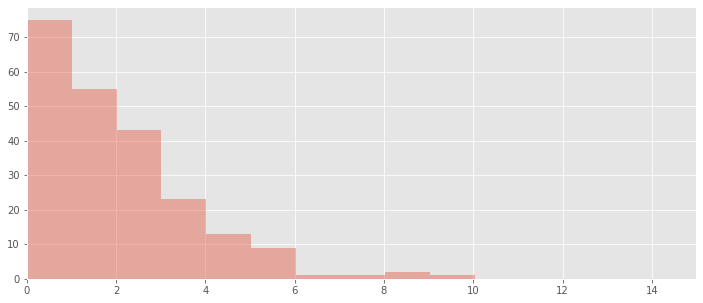

In [68]:
plt.figure()
sns.distplot(np.square(dist_train),
             bins = 10, 
             kde= False);
plt.xlim([0.0,15])

Text(0.5, 0, 'Mahalanobis dist')

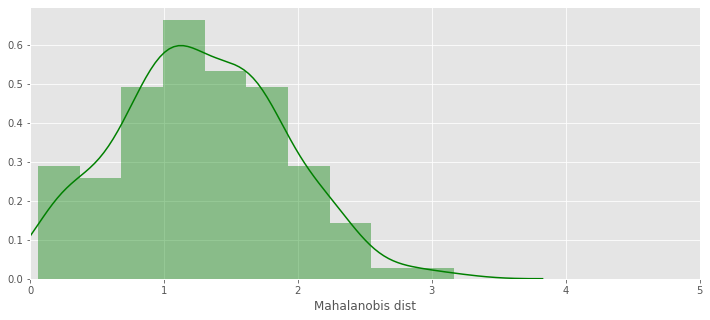

In [69]:
plt.figure()
sns.distplot(dist_train,
             bins = 10, 
             kde= True, 
            color = 'green');
plt.xlim([0.0,5])
plt.xlabel('Mahalanobis dist')

In [70]:
anomaly_train = pd.DataFrame()
anomaly_train['Mob dist']= dist_train
anomaly_train['Thresh'] = threshold
# If Mob dist above threshold: Flag as anomaly
anomaly_train['Anomaly'] = anomaly_train['Mob dist'] > anomaly_train['Thresh']
anomaly_train.index = X_train_PCA.index
anomaly = pd.DataFrame()
anomaly['Mob dist']= dist_test
anomaly['Thresh'] = threshold
# If Mob dist above threshold: Flag as anomaly
anomaly['Anomaly'] = anomaly['Mob dist'] > anomaly['Thresh']
anomaly.index = X_test_PCA.index
anomaly.head()

,Mob dist,Thresh,Anomaly
2004-02-13 23:52:39,1.035972,3.818011,False
2004-02-14 00:02:39,1.133269,3.818011,False
2004-02-14 00:12:39,1.514723,3.818011,False
2004-02-14 00:22:39,1.812835,3.818011,False
2004-02-14 00:32:39,0.787156,3.818011,False


In [71]:
anomaly_alldata = pd.concat([anomaly_train, anomaly])
anomaly_alldata.to_csv('Anomaly_distance.csv')

### 6. 결과확인

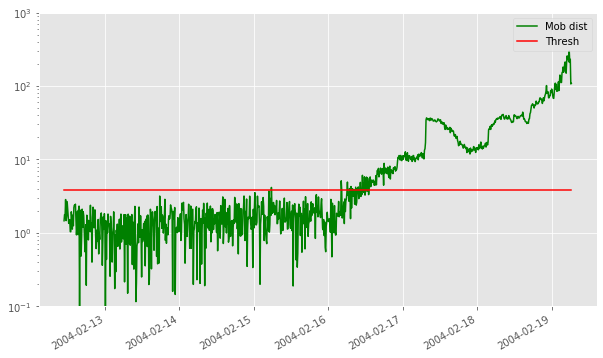

In [72]:
anomaly_alldata.plot(logy=True, figsize = (10,6), ylim = [1e-1,1e3], color = ['green','red'])